# 1. Mount Google Drive

In [ ]:
from google.colab import drive
 
drive.mount('/gdrive')
%cd /gdrive/'My Drive'/object_detection

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/object_detection


2. Install Required Packages

In [ ]:
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -qq Cython contextlib2 pillow lxml matplotlib pycocotools

Selecting previously unselected package python-bs4.
(Reading database ... 144379 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpacking pyt

3. Importing Libraries

In [ ]:
#@title
%tensorflow_version 1.x
from __future__ import division, print_function, absolute_import

import pandas as pd
import numpy as np
import csv

import re
import os
import io
import glob
import shutil
import urllib.request
import tarfile
import xml.etree.ElementTree as ET

import tensorflow.compat.v1 as tf
import cv2 

from PIL import Image
from collections import namedtuple, OrderedDict

from google.colab import files
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


Download object detection API

In [ ]:
#@title
# downloads the models
!git clone --q https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


Complie and export

In [ ]:
%cd /gdrive/My Drive/object_detection/models/research
# compils the proto buffers
!protoc object_detection/protos/*.proto --python_out=.
#  ModuleNotFoundError: No module named 'tf_slim'
!pip install tf_slim
# exports PYTHONPATH environment var with research and slim paths
os.environ['PYTHONPATH'] += ':./:./slim/'

/gdrive/My Drive/object_detection/models/research
object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.
     |████████████████████████████████| 358kB 8.8MB/s 


In [ ]:
# testing the model builder
!python3 object_detection/builders/model_builder_test.py
print('OK')

OK


Convert xml to csv

In [ ]:
#@title
%cd /gdrive/My Drive/object_detection/data/
#adjusted from: https://github.com/datitran/raccoon_dataset
def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text,
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)

Create tfrecords and lable map

In [ ]:
#os.environ['PYTHONPATH'] = os.pathsep.join(os.environ['PYTHONPATH'].split(os.pathsep)[:-1])
print(os.environ['PYTHONPATH'])

/tensorflow-1.15.2/python3.6:/env/python:./:./slim/


In [ ]:
#@title
%cd /gdrive/My Drive/object_detection/models/research
#adjusted from: https://github.com/datitran/raccoon_dataset
from object_detection.utils import dataset_util


#change this to the base directory where your data/ is 
data_base_url = '/gdrive/My Drive/object_detection/data/'

#location of images
image_dir = data_base_url +'images/'
'''
def class_text_to_int(row_label):
	if row_label == 'teemo':
		return 1
	else:
		None
'''
def class_text_to_int(row_label):
  if row_label == 'adapter':
    return 1
  if row_label == 'apple':
    return 2
  if row_label == 'banana':
    return 3
  if row_label == 'kangaroo':
    return 4
  if row_label == 'orange':
    return 5
  if row_label == 'raccoon':
    return 6
  if row_label == 'teemo':
    return 7  
  else:
    None

def split(df, group):
  data = namedtuple('data', ['filename', 'object'])
  gb = df.groupby(group)
  return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
	with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
	  encoded_jpg = fid.read()
	encoded_jpg_io = io.BytesIO(encoded_jpg)
	image = Image.open(encoded_jpg_io)
	width, height = image.size
	filename = group.filename.encode('utf8')
	image_format = b'jpg'
	xmins = []
	xmaxs = []
	ymins = []
	ymaxs = []
	classes_text = []
	classes = []

	for index, row in group.object.iterrows():
		xmins.append(row['xmin'] / width)
		xmaxs.append(row['xmax'] / width)
		ymins.append(row['ymin'] / height)
		ymaxs.append(row['ymax'] / height)
		classes_text.append(row['class'].encode('utf8'))
		classes.append(class_text_to_int(row['class']))

	tf_example = tf.train.Example(features=tf.train.Features(feature={
		'image/height': dataset_util.int64_feature(height),
		'image/width': dataset_util.int64_feature(width),
		'image/filename': dataset_util.bytes_feature(filename),
		'image/source_id': dataset_util.bytes_feature(filename),
		'image/encoded': dataset_util.bytes_feature(encoded_jpg),
		'image/format': dataset_util.bytes_feature(image_format),
		'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
		'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
		'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
		'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
		'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
		'image/object/class/label': dataset_util.int64_list_feature(classes),
		}))
	return tf_example
#creates tfrecord for both csv's
for csv in ['train_labels', 'test_labels']:
  writer = tf.io.TFRecordWriter(data_base_url + csv + '.record')
  path = os.path.join(image_dir)
  examples = pd.read_csv(data_base_url + csv + '.csv')
  grouped = split(examples, 'filename')
  for group in grouped:
    tf_example = create_tf_example(group, path)
    writer.write(tf_example.SerializeToString())
    
  writer.close()
  output_path = os.path.join(os.getcwd(), data_base_url + csv + '.record')

/gdrive/My Drive/object_detection/models/research


In [ ]:
#@title
DEST_DIR = '/gdrive/My Drive/object_detection/models/research/pretrained_model'

#model to use
MODEL = 'ssd_mobilenet_v2_coco_2018_03_29'
MODEL_FILE = MODEL + '.tar.gz'

#downlaod link
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
#checks if downloaded
if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
#unzip
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()
# creat output file 
os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

In [ ]:
#change config file locally and uplad it to the Drive
#added 90 deg flip, dropou, num_vizuali changed, batch size to 8, 20 max_evals, shuffle input

Prepare tensorbard

In [ ]:
#@title
%cd gdrive/My Drive/object_detection/data
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

[Errno 2] No such file or directory: 'gdrive/My Drive/object_detection/data'
/gdrive/My Drive/object_detection/models/research
--2020-07-06 12:46:01--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.70.230.150, 34.231.196.161, 54.152.45.100, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.70.230.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.3’

ngrok-stable-linux- 100%[===================>]  13.13M  10.9MB/s    in 1.2s    

2020-07-06 12:46:02 (10.9 MB/s) - ‘ngrok-stable-linux-amd64.zip.3’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:

#the logs that are created while training 
LOG_DIR = "training/"
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
#The link to tensorboard.
#works after the training starts.
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://21f2778a556e.ngrok.io


#Train model

In [ ]:
%cd /gdrive/My Drive/object_detection/models/research/
#check config file
!cat object_detection/samples/configs/ssd_mobilenet_v2_coco.config
!cat ../../data/label_map.pbtxt

In [ ]:
!python3 object_detection/model_main.py \
    --pipeline_config_path=/gdrive/My\ Drive/object_detection/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config \
    --model_dir=training/

W0706 12:51:19.553885 140325942286208 model_lib.py:717] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: None
I0706 12:51:19.554137 140325942286208 config_util.py:551] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0706 12:51:19.554229 140325942286208 config_util.py:551] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0706 12:51:19.554344 140325942286208 config_util.py:551] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0706 12:51:19.554435 140325942286208 config_util.py:551] Maybe overwriting eval_num_epochs: 1
INFO:tensorflow:Maybe overwriting load_pretrained: True
I0706 12:51:19.554513 140325942286208 config_util.py:551] Maybe overwriting load_pretrained: True
INFO:tensorflow:Ignoring config override key: load_pretrained
I0706 12:51:19.554592 140325942286208 config_util.py:5

Find last checkpoint and export frozen graph

In [ ]:
%cd /gdrive/My Drive/object_detection/models/research/
#dir where the model will be saved
output_directory = '"/gdrive/My Drive/object_detection/data/fine_tuned_model"'

lst = os.listdir('training')
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join('training', last_model)
print(last_model_path)

/gdrive/My Drive/object_detection/models/research
training/model.ckpt-20654


In [ ]:
!python "/gdrive/My Drive/object_detection/models/research/object_detection/export_inference_graph.py" \
    --input_type=image_tensor \
    --pipeline_config_path object_detection/samples/configs/ssd_mobilenet_v2_coco.config \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

Instructions for updating:
Please use `layer.__call__` method instead.
W0628 16:38:31.600470 140554406573952 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0628 16:38:33.563036 140554406573952 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0628 16:38:33.602432 140554406573952 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0628 16:38:33.730491 140554406573952 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

#Test model

In [ ]:
#WARNING: Check num_classes!
pb_fname = '/gdrive/My Drive/object_detection/data/fine_tuned_model/frozen_inference_graph.pb'
label_map_pbtxt_fname = '/gdrive/My Drive/object_detection/data/label_map.pbtxt'
repo_dir_path = '/gdrive/My Drive/object_detection/data/'
num_classes = 7

In [ ]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/gdrive/My Drive/object_detection/data/test/00119.jpg', '/gdrive/My Drive/object_detection/data/test/img3.jpg', '/gdrive/My Drive/object_detection/data/test/img5.jpg', '/gdrive/My Drive/object_detection/data/test/img2.jpg', '/gdrive/My Drive/object_detection/data/test/img1.jpg', '/gdrive/My Drive/object_detection/data/test/orange_53.jpg', '/gdrive/My Drive/object_detection/data/test/teemo_00025.jpg', '/gdrive/My Drive/object_detection/data/test/teemo_00051.jpg', '/gdrive/My Drive/object_detection/data/test/images.jpg', '/gdrive/My Drive/object_detection/data/test/ch.jpg']


/gdrive/My Drive/object_detection/models/research/object_detection


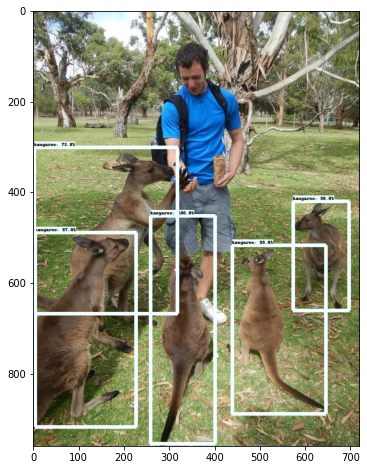

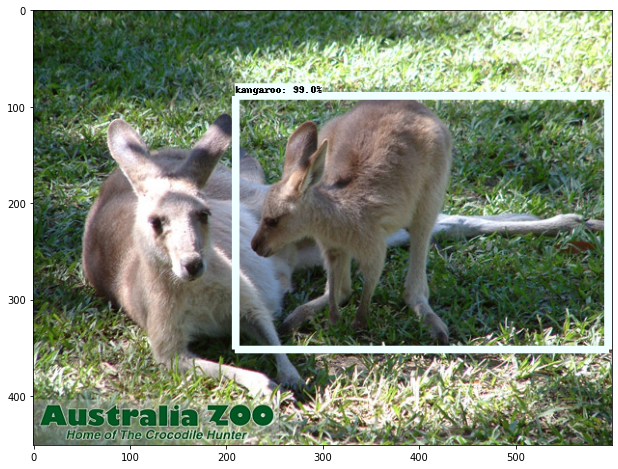

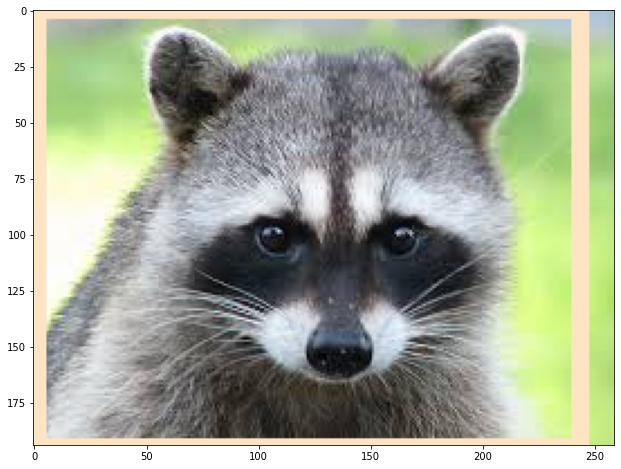

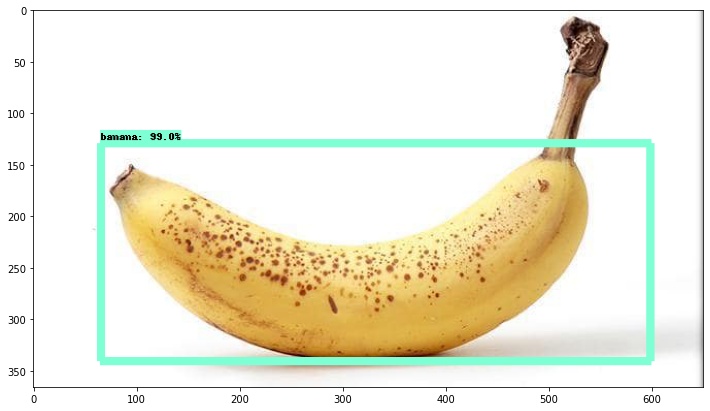

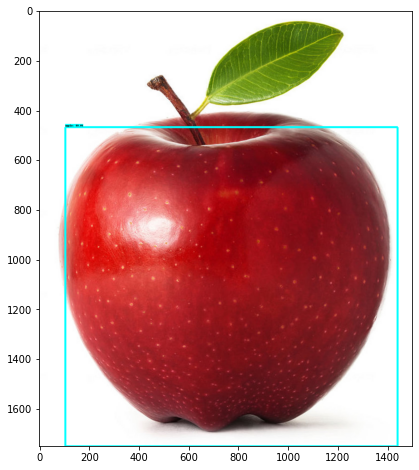

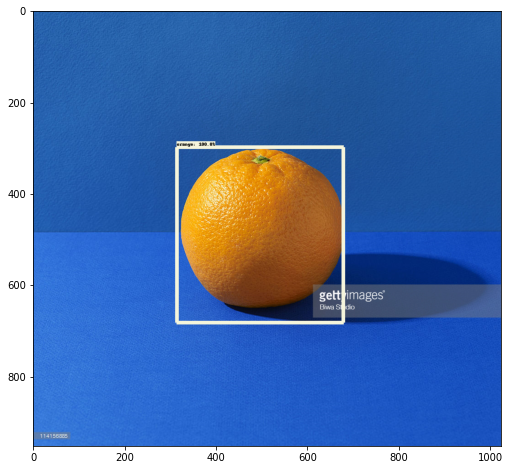

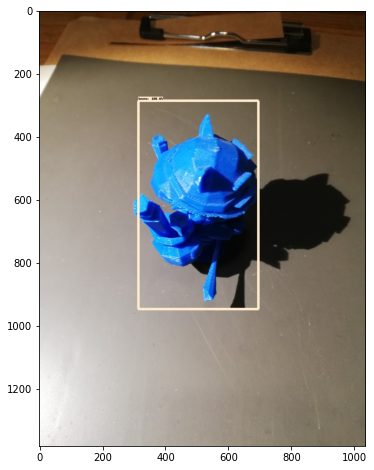

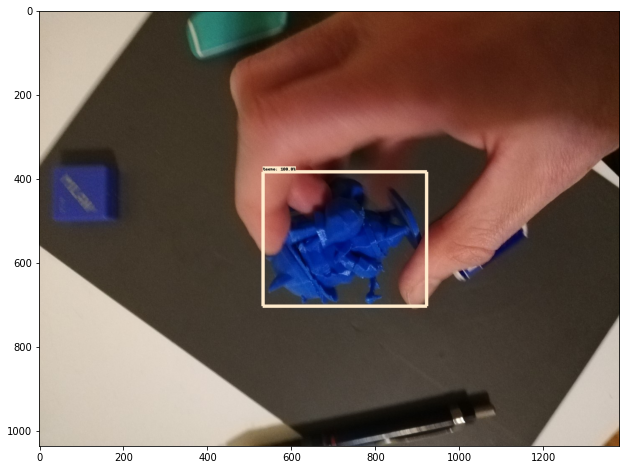

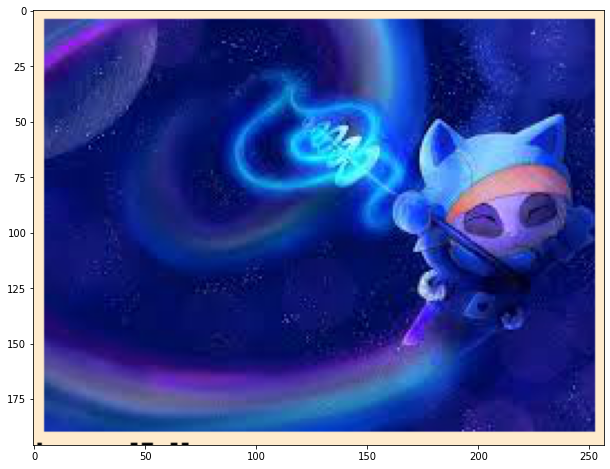

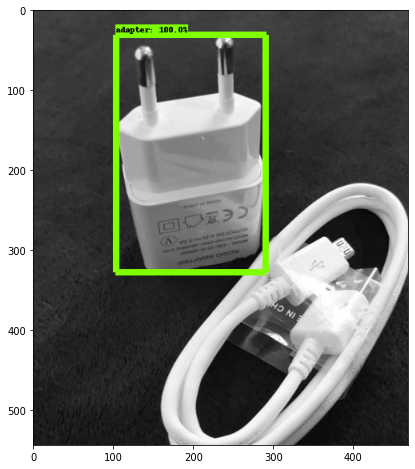

In [ ]:
%cd /gdrive/My Drive/object_detection/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)